# HW1: Materials Data Extraction & Featurization (Spring 2026)

## Prerequisites: Environment Setup

Before you begin, please set up your Python environment. All required packages for this assignment are listed in the `pyproject.toml` file.

**Setup Steps:**
1.  Navigate to the `HW1` directory in your terminal.
2.  Create a virtual environment: `uv venv`
3.  Activate the environment: `source .venv/bin/activate` (or `.venv\Scripts\activate` on Windows).
4.  Install all dependencies, including optional ones for Part 2 and Part 4:
    ```bash
    uv pip install -e .[knowmat2,nomad]
    ```

## Part 1: Materials Project API Data Extraction

### Task 1.1: Setup and Import Libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.core import Structure, Element
import os

In [88]:
import os
from pathlib import Path

api_key ="n
# --------------------------------------------------
# Option 1: Environment variable (recommended)
# --------------------------------------------------
#api_key = os.getenv("MP_API_KEY")


# --------------------------------------------------
# Option 2: File outside the GitHub repo
# --------------------------------------------------
# Expected location:
#   <course root>/mp-apikey.txt

if not api_key:
    cwd = Path.cwd()
    api_key_path = cwd.parents[2] / "mp-apikey.txt"  # go up 3 levels

    try:
        api_key = api_key_path.read_text().strip()
    except FileNotFoundError:
        pass


# --------------------------------------------------
# Option 3: Direct assignment (NOT recommended)
# --------------------------------------------------
# api_key = "your_api_key_here"


# --------------------------------------------------
# Final check
# --------------------------------------------------
if not api_key:
    print("⚠️ Warning: No Materials Project API key found.")
    print(f"Tried: {api_key_path if 'api_key_path' in locals() else 'MP_API_KEY env var'}")
else:
    print("✅ Materials Project API key loaded.")

✅ Materials Project API key loaded.


### Task 1.2: Let's explore materials containing Be (Beryllium) or Mg (Magnesium). Create a search that finds all non-unary beryllium- or magnesium-containing materials with:
- Band gap between 0.5 - 3.0 eV
- Density between 2.0 - 4.0 g/cm³

**Note on API Data:** The number of materials returned by an API query can change over time. Don't worry if your count doesn't exactly match a specific number, as long as your query is correct.

In [89]:

FIELDS=["material_id", "formula_pretty", "band_gap", "density", "energy_above_hull"]
def query_contains(element: str):
    return mpr.materials.summary.search(
        elements=[element],
        num_elements=(2, None),  # non-unary: at least 2 elements
        band_gap=(0.5, 3.0),     # eV
        density=(2.0, 4.0),      # eV
        fields=FIELDS
    )

with MPRester(api_key) as mpr:
    docs_mg = query_contains("Mg")
    docs_be = query_contains("Be")

# Union by material_id to avoid double counting if any material contains BOTH Be and Mg
by_id = {d.material_id: d for d in docs_mg}
by_id.update({d.material_id: d for d in docs_be})

docs_union = list(by_id.values())

df = pd.DataFrame([
        {
            "material_id": doc.material_id,
            "formula": doc.formula_pretty,
            "band_gap": doc.band_gap,
            "density": doc.density,
            "e_above_hull": doc.energy_above_hull
        }
        for doc in docs_union
    ])

print(f"Mg-containing matches: {len(docs_mg)}")
print(f"Be-containing matches: {len(docs_be)}")
print(f"Total unique (Be OR Mg) matches: {len(docs_union)}")

print(df.tail())

Retrieving SummaryDoc documents: 100%|██████████| 70/70 [00:00<00:00, 70122.11it/s]

Mg-containing matches: 2738
Be-containing matches: 70
Total unique (Be OR Mg) matches: 2807
     material_id          formula  band_gap   density  e_above_hull
2802    mp-21535   Mn4Be3Ge3SeO12    2.5408  3.819995      0.000000
2803    mp-21616    Mn4Be3Ge3SO12    2.4229  3.650366      0.000000
2804  mp-1227653    Ca4Be4P4O17F3    0.7893  2.927120      0.037011
2805  mp-1227528    Be6Al4Si12O37    0.7828  2.604828      0.040265
2806  mp-1266607  Y5Be6Fe3(SiO5)6    1.8422  3.998557      0.050114


### Tasks 1.3 - 1.12: Data Analysis and Cleaning
Follow the instructions in the markdown file for tasks 1.3 through 1.12. This involves finding the material with the highest band gap, checking its stability, visualizing, and performing data cleaning steps. Note that specific row/shape counts have been removed from the instructions, as they will vary based on the initial API query.

Highest band gap material:
Formula:  Ba6Mg7H26
Band gap: 2.996 eV
Stable? True


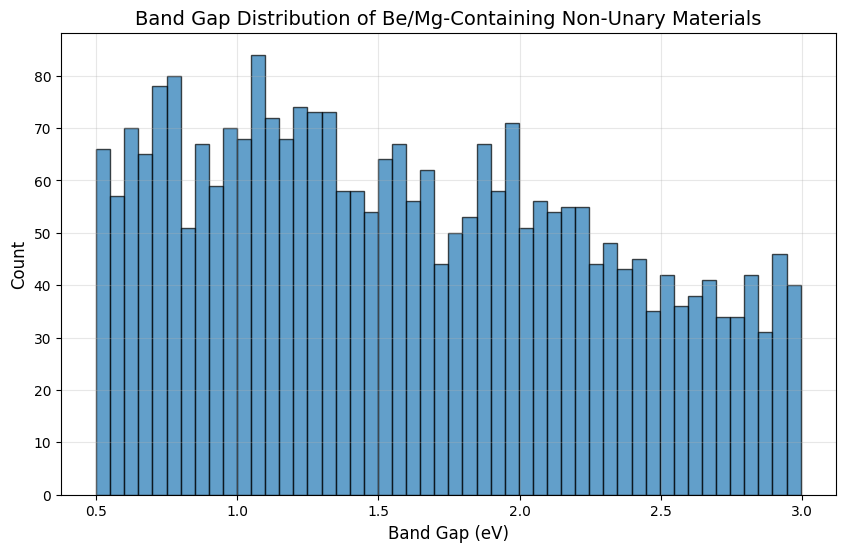

First 10 rows:
  formula  band_gap
0     MgO    2.2025
1     MgO    1.9229
2     MgO    2.8658
3     MgO    1.8773
4     MgO    1.9477
5     MgO    2.0815
6     MgO    2.0750
7     MgO    1.8877
8    MgC2    2.5620
9    MgP4    0.7289

Shape of dataframe:
(2807, 2)
DataFrame copied successfully.
Number of duplicate rows: 0

Formulas with duplicate entries:
Shape before removing duplicates: (2807, 2)
Shape after removing duplicates: (2807, 2)
First 10 rows of condensed dataframe:
           formula  band_gap
0         Ba(MgP)2  1.136600
1     Ba2Mg(TiS3)2  0.678300
2          Ba2MgH6  2.886400
3  Ba2MgMn2(P2O7)2  1.407900
4  Ba2MgMo4(P2O7)4  2.106700
5  Ba2MgV2(Si2O7)2  1.831667
6     Ba3Zr6BeCl18  1.013500
7  Ba4MgMn4(P2O7)4  1.190650
8     Ba6Mg(P2O7)3  1.245150
9        Ba6Mg7H26  2.995900

Shape before condensing formulas: (2807, 2)
Shape after condensing formulas: (1736, 2)
Selected duplicated formula for validation: MgV4O7F5

Duplicate entries in original dataframe:
      formula 

In [90]:
# Task 1.3: Identify Highest Band Gap Material
# Remove rows with missing band gap (just to be safe)
df_clean = df.dropna(subset=["band_gap"])

# Find the row with maximum band gap
idx_max = df_clean["band_gap"].idxmax()
max_row = df_clean.loc[idx_max]

print("Highest band gap material:")
print(f"Formula:  {max_row['formula']}")
print(f"Band gap: {max_row['band_gap']:.3f} eV")

# Task 1.4: Check Material Stability
stable = max_row["e_above_hull"] <= 1e-6
print(f"Stable? {stable}")

# Task 1.5: Visualize Band Gap Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['band_gap'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Band Gap (eV)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Band Gap Distribution of Be/Mg-Containing Non-Unary Materials', fontsize=14)
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig("bandgap_distribution.png", dpi=300, bbox_inches="tight")

plt.show()


# Task 1.6: Create DataFrame

df_task16 = df[['formula', 'band_gap']].copy()

# Print first 10 rows
print("First 10 rows:")
print(df_task16.head(10))

# Print shape of the dataframe
print("\nShape of dataframe:")
print(df_task16.shape)

# Task 1.7: Copy and Explore Data
df_copy = f_task16.copy()

print("DataFrame copied successfully.")


# Task 1.8: Identify Duplicates
# Find duplicated rows (keep=False marks all duplicates, not just later ones)
dup_rows = df_copy[df_copy.duplicated(subset=["formula", "band_gap"], keep=False)]

# Number of duplicate rows
num_dup_rows = dup_rows.shape[0]

print(f"Number of duplicate rows: {num_dup_rows}")

# Report which formulas have duplicate entries
dup_formulas = dup_rows["formula"].unique()

print("\nFormulas with duplicate entries:")
for f in dup_formulas:
    print(f)

# Task 1.9: Remove Duplicate Rows

print("Shape before removing duplicates:", df_task16.shape)

df_task16_nodup = df_copy.drop_duplicates(subset=["formula", "band_gap"])

print("Shape after removing duplicates:", df_task16_nodup.shape)



# Task 1.10: Handle Formula Duplicates

# Code to calculate mean values for duplicate formulas
df_formula_mean = (
    df_task16_nodup
    .groupby("formula", as_index=False)["band_gap"]
    .mean()
)

# Replace duplicate entries with mean values (now each formula appears once)
df_task110 = df_formula_mean.copy()


print("First 10 rows of condensed dataframe:")
print(df_task110.head(10))

print("\nShape before condensing formulas:", df_task16_nodup.shape)
print("Shape after condensing formulas:", df_task110.shape)



# Task 1.11: Validate Averaging
# 1) Identify a formula that has duplicates in the original dataframe
dup_formula = df_task16_nodup["formula"].value_counts()
dup_formula = dup_formula[dup_formula > 1].index[0]   # pick the first duplicated formula

print(f"Selected duplicated formula for validation: {dup_formula}")

# 2) Filter the original dataframe for this formula
df_dup = df_task16_nodup[df_task16_nodup["formula"] == dup_formula]

print("\nDuplicate entries in original dataframe:")
print(df_dup)

# 3) Compute mean band gap of duplicates
mean_bg = df_dup["band_gap"].mean()

# 4) Get averaged value from condensed dataframe
avg_bg = df_task110.loc[df_task110["formula"] == dup_formula, "band_gap"].values[0]

# 5) Verify
is_correct = np.isclose(mean_bg, avg_bg, rtol=1e-9, atol=1e-9)

print("\nVerification Results:")
print(f"Mean band gap from duplicates: {mean_bg:.6f} eV")
print(f"Averaged band gap in df_task110: {avg_bg:.6f} eV")
print(f"Validation passed? {is_correct}")

# Task 1.12: Drop Duplicates
print("Shape before dropping duplicates:", df_task16_nodup.shape)

# Drop duplicate formulas (each formula appears once)
df_task112 = df_task16_nodup.drop_duplicates(subset=["formula"], keep="first")

print("Shape after dropping duplicates:", df_task112.shape)

# Verify expected reduction
n_unique_formulas = df_task16_nodup["formula"].nunique()

print("\nVerification:")
print("Unique formulas expected:", n_unique_formulas)
print("Rows after dropping duplicates:", df_task112.shape[0])
print("Validation passed?", df_task112.shape[0] == n_unique_formulas)

## Part 2: Import a featurizer that has been developed by our group: CBFV (Composition-Based Feature Vector).

There are a few different featurizers that can be used:
- oliynyk (default)
- onehot
- mat2vec

### Task 2.1: Verify Your Setup
After following the setup and configuration guides in `HW1_instructions.md`, run the verification script to ensure KnowMat2 and Ollama are configured correctly.

In [91]:
# Task 2.1: Import CBFV

from CBFV import composition

# Task 2.2: Prepare Datasets
#df = pd.DataFrame(df_mean, columns=['formula', 'target'])
df = df_mean.rename(columns={"band_gap": "target"})
df_oli, y_oli, formulae_oli, skipped_oli = composition.generate_features(df, elem_prop='oliynyk')
df_onehot, y_onehot, formulae_onehot, skipped_onehot = composition.generate_features(df, elem_prop='onehot')
df_mat2vec, y_mat2vec, formulae_mat2vec, skipped_mat2vec = composition.generate_features(df, elem_prop='mat2vec')

#print(df_mat2vec.head())


Processing Input Data: 100%|██████████| 1736/1736 [00:00<00:00, 23171.33it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1736/1736 [00:00<00:00, 17761.12it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1736/1736 [00:00<00:00, 2060.72it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1736/1736 [00:00<00:00, 18706.05it/s]


	Creating Pandas Objects...


Processing Input Data: 100%|██████████| 1736/1736 [00:00<00:00, 21072.27it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1736/1736 [00:00<00:00, 16678.18it/s]


	Creating Pandas Objects...


### Use CBFV to create features for each of the 3 datasets.


In [92]:
# Task 2.3: Import CBFV and verify it works
# Print shapes of each featurized dataset
print("Featurized dataset shapes:")
print(f"oliynyk: X = {df_oli.shape}, y = {y_oli.shape}, skipped = {len(skipped_oli)}")
print(f"onehot:  X = {df_onehot.shape}, y = {y_onehot.shape}, skipped = {len(skipped_onehot)}")
print(f"mat2vec: X = {df_mat2vec.shape}, y = {y_mat2vec.shape}, skipped = {len(skipped_mat2vec)}")

Featurized dataset shapes:
oliynyk: X = (1736, 264), y = (1736,), skipped = 0
onehot:  X = (1736, 714), y = (1736,), skipped = 0
mat2vec: X = (1736, 1200), y = (1736,), skipped = 0


### Tasks 2.2 - 2.5: Literature Data Extraction
Follow the instructions in the markdown file for tasks 2.2 through 2.5. This involves identifying relevant papers, extracting data, comparing with Materials Project, and writing your discussion.

In [84]:
# Your code for tasks 2.2 - 2.5 here

# Task 2.4: Train and Evaluate Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

RNG_SEED = 42
np.random.seed(seed=RNG_SEED)

def train_eval_rf(X, y, name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=RNG_SEED)
    rf = RandomForestRegressor(max_depth=2, random_state=0)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    rmse_val = mean_squared_error(y_test, y_pred)


    print(f"{name} -> X_train: {X_train.shape}, X_test: {X_test.shape}, MSE: {rmse_val:.6f}")
    return rmse_val
  
mse_oli = train_eval_rf(df_oli, y_oli, "oliynyk")
mse_onehot = train_eval_rf(df_onehot, y_onehot, "onehot")
mse_mat2vec = train_eval_rf(df_mat2vec, y_mat2vec, "mat2vec")

print("\nMean Squared Error (MSE) Summary:")
print(f"oliynyk: {mse_oli:.6f}")
print(f"onehot:  {mse_onehot:.6f}")
print(f"mat2vec: {mse_mat2vec:.6f}")

oliynyk -> X_train: (1163, 264), X_test: (573, 264), MSE: 0.446906
onehot -> X_train: (1163, 714), X_test: (573, 714), MSE: 0.467693
mat2vec -> X_train: (1163, 1200), X_test: (573, 1200), MSE: 0.429309

Mean Squared Error (MSE) Summary:
oliynyk: 0.446906
onehot:  0.467693
mat2vec: 0.429309


#### The mat2vec featurizer produced the best model because it achieved the lowest MSE = 0.429309 (lower MSE means better predictive performance). Mat2vec likely performed best because it provides a richer and more expressive representation of chemical compositions compared to oliynyk and onehot. Unlike onehot encoding (which is sparse and mainly captures element presence), mat2vec embeddings encode chemical similarity and relationships between elements learned from large materials science text corpora.

## Part 3: Data Repository Integration - NOMAD

In [ ]:
# Task 3.1: Setup NOMAD Access

import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# NOMAD API base URL
BASE_URL = "https://nomad-lab.eu/prod/rae/api"

# Headers for requests (only Accept header for GET requests)
headers = {
    'Accept': 'application/json'
}

In [96]:
import nomad

print("✅ NOMAD imported successfully")

✅ NOMAD imported successfully


In [102]:
from nomad.client import api

url = "https://nomad-lab.eu/prod/v1/api/v1/entries/query"

payload = {
    "query": {},       # no filtering, just return something
    "pagination": {
        "page_size": 1
    }
}

r = requests.post(url, json=payload)
r.raise_for_status()
data = r.json()

print("Connected to NOMAD REST API successfully")
print("Keys:", data.keys())
print("Number of entries returned:", len(data.get("data", [])))

Connected to NOMAD REST API successfully
Keys: dict_keys(['owner', 'query', 'pagination', 'data'])
Number of entries returned: 1


In [107]:
# Task 3.2: Browse NOMAD Database

BASE_URL = "https://nomad-lab.eu/prod/v1/api/v1/entries/query"

payload = {
    "query": {
        "results.material.elements": {"all": ["Be"]}
    },
    "pagination": {"page_size": 3}
}

response = requests.post(BASE_URL, json=payload)
data = response.json()

# total entries in NOMAD that match this query
total_entries = data["pagination"]["total"]
print("Total Be-containing entries found:", total_entries)

# show metadata for 3 entries
entries = data["data"]

for i, entry in enumerate(entries, start=1):
    entry_id = entry.get("entry_id", "N/A")
    formula = entry.get("results", {}).get("material", {}).get("chemical_formula_hill", "N/A")
    props = entry.get("results", {}).get("properties", {})

    print(f"\nEntry {i}")
    print("Entry ID:", entry_id)
    print("Formula:", formula)
    print("Properties available:", list(props.keys()) if isinstance(props, dict) else "N/A")


Total Be-containing entries found: 645003

Entry 1
Entry ID: ---hc8_hXpe8X0J1ibGSATQeJh4O
Formula: AlBeLuSc
Properties available: ['available_properties', 'n_calculations', 'electronic']

Entry 2
Entry ID: --0Hj5fqGLafCh90yCg1gBBRRlKo
Formula: Be3Os
Properties available: ['available_properties', 'n_calculations', 'structures', 'geometry_optimization']

Entry 3
Entry ID: --0Wis-_eSopytwVd1dn2NRN1L0Y
Formula: Be6Te7
Properties available: ['available_properties', 'n_calculations', 'electronic', 'mechanical', 'geometry_optimization']


In [108]:
# 1) Download BeO entries from NOMAD
url = "https://nomad-lab.eu/prod/v1/api/v1/entries/query"

payload = {
    "query": {"results.material.chemical_formula_hill": "BeO"},
    "pagination": {"page_size": 50}
}

response = requests.post(url, json=payload)
data = response.json()

entries = data["data"]
print("Total BeO entries available:", data["pagination"]["total"])
print("Entries downloaded:", len(entries))

# 2) Extract useful info (entry_id, formula)
rows = []
for e in entries:
    entry_id = e.get("entry_id", "N/A")
    formula = e.get("results", {}).get("material", {}).get("chemical_formula_hill", "N/A")
    rows.append({"entry_id": entry_id, "formula": formula})

df_nomad = pd.DataFrame(rows)

# 3) Save file
df_nomad.to_csv("nomad_downloaded_data.csv", index=False)
print("\nSaved file: nomad_downloaded_data.csv")

# 4) Summary stats
print("\nSummary:")
print("Number of entries in file:", df_nomad.shape[0])
print("Number of unique formulas:", df_nomad["formula"].nunique())

Total BeO entries available: 1292
Entries downloaded: 50

Saved file: nomad_downloaded_data.csv

Summary:
Number of entries in file: 50
Number of unique formulas: 1


# Data Repository Comparison: Materials Project vs NOMAD

## Comparison Paragraph
Materials Project (MP) and NOMAD are both widely used data repositories in materials science, but they serve different purposes and provide data in different ways. Materials Project is designed primarily as a curated database of computed materials properties, and it provides structured, standardized outputs such as band gap, density, and stability metrics that are straightforward to query through a well-organized API. In contrast, NOMAD functions more as a large-scale archive for computational materials science workflows, containing diverse datasets uploaded from many codes and research groups. As a result, NOMAD offers broader coverage of raw computational data and metadata, but the availability of specific properties (such as band gap) can vary across entries and may not appear in consistent locations within the API response. Overall, Materials Project is more convenient for building clean property datasets for machine learning, while NOMAD is better suited for exploring computational provenance, workflow-level data, and heterogeneous simulation archives, although integration often requires additional processing and careful validation.

---

## Comparison Table

| Criterion | Materials Project (MP) | NOMAD |
|---|---|---|
| Primary purpose | Curated database of computed materials properties | Archive/repository of computational materials science results |
| Data availability & coverage | Strong coverage for standardized DFT-derived properties across many materials | Very large and diverse coverage; includes many workflows, codes, and raw results |
| API usability | Consistent query structure; simple property-based filtering | API is flexible but more complex; client/version issues may occur |
| Data format & standardization | Highly standardized schema; easy to build clean datasets | Less standardized across uploads; property fields may differ between entries |
| Metadata quality | Strong curated metadata (e.g., stability, band gap, density) | Metadata richness varies; depends on parser and upload source |
| Best use case | Rapid dataset building, ML-ready property datasets, screening materials | Exploring raw computational results, provenance, workflow diversity |
| Limitations | Limited to MP’s computed dataset and schema; less raw workflow detail | Integration harder due to inconsistent property availability and formats |

---


In [110]:

from pymatgen.core.composition import Composition

def norm_formula(f):
    try:
        return Composition(str(f)).reduced_formula
    except:
        return str(f)

# -----------------------------
# 1) Materials Project dataset
# -----------------------------
# df_mean must have: formula, band_gap
df_mp = df_mean[["formula", "band_gap"]].copy()
df_mp = df_mp.rename(columns={"band_gap": "mp_band_gap"})
df_mp["formula_norm"] = df_mp["formula"].apply(norm_formula)

# -----------------------------
# 2) NOMAD dataset (Task 3.3)
# -----------------------------
df_nomad = pd.read_csv("nomad_downloaded_data.csv")   # has entry_id, formula
df_nomad["formula_norm"] = df_nomad["formula"].apply(norm_formula)

# -----------------------------
# 3) JARVIS-DFT dataset
# -----------------------------
df_jarvis = pd.DataFrame()
try:
    from jarvis.db.figshare import data as jarvis_data
    jar = pd.DataFrame(jarvis_data("dft_3d"))

    # formula column
    jar["formula_norm"] = jar["formula"].apply(norm_formula)

    # band gap column (try common names)
    bg_col = None
    for c in ["bandgap", "mbj_bandgap", "optb88vdw_bandgap"]:
        if c in jar.columns:
            bg_col = c
            break

    if bg_col is not None:
        df_jarvis = jar[["formula_norm", bg_col]].rename(columns={bg_col: "jarvis_band_gap"})
    else:
        df_jarvis = jar[["formula_norm"]].copy()
        df_jarvis["jarvis_band_gap"] = np.nan

except Exception as e:
    print("JARVIS load failed.")
    print("Error:", e)
    df_jarvis = pd.DataFrame(columns=["formula_norm", "jarvis_band_gap"])

# -----------------------------
# 4) Merge (attempt)
# -----------------------------
merged = df_mp.merge(df_nomad[["formula_norm", "entry_id"]], on="formula_norm", how="left")
merged = merged.merge(df_jarvis, on="formula_norm", how="left")

# -----------------------------
# 5) Print stats (required)
# -----------------------------
print("MP materials:", df_mp["formula_norm"].nunique())
print("NOMAD materials:", df_nomad["formula_norm"].nunique())
print("JARVIS materials:", df_jarvis["formula_norm"].nunique())

mp_set = set(df_mp["formula_norm"])
nomad_set = set(df_nomad["formula_norm"])
jarvis_set = set(df_jarvis["formula_norm"])

print("Overlap (MP ∩ NOMAD):", len(mp_set & nomad_set))
print("Overlap (MP ∩ NOMAD ∩ JARVIS):", len(mp_set & nomad_set & jarvis_set))

# Example property comparison (MP vs JARVIS band gap)
tmp = merged.dropna(subset=["mp_band_gap", "jarvis_band_gap"])
print("MP vs JARVIS band gap comparable rows:", tmp.shape[0])
if tmp.shape[0] > 0:
    print(tmp[["formula_norm", "mp_band_gap", "jarvis_band_gap"]].head(5))

# -----------------------------
# 6) Save merged data
# -----------------------------
merged.to_csv("integrated_dataset.csv", index=False)
print("Saved: integrated_dataset.csv")


JARVIS load failed.
Error: No module named 'jarvis'
MP materials: 1736
NOMAD materials: 1
JARVIS materials: 0
Overlap (MP ∩ NOMAD): 0
Overlap (MP ∩ NOMAD ∩ JARVIS): 0
MP vs JARVIS band gap comparable rows: 0
Saved: integrated_dataset.csv


#### NOMAD returned formulas but often did not include band gap in the simple query output, so direct property comparison is limited.Even with normalized formulas, overlap can be small because each database covers different computations, methods, and metadata completeness.